''' 
    This is a customizable script that allow you to run a simulation of the hippocampal Schaffer collateral 
    synaptic transimmsion.
    
    The proposed protocol is composed of 4 different steps, that must be run sequentially:
    
    1) Design of the stimulation protocol
    2) Gating kinetic simulation of AMPARs and NMDARs
    3) Calculation of the evoked synaptic currents and depolarization's potentials
    4) Kinetic simulation of the autophosphorilation of post-synaptic CaMKII enzyme
    
    
'''


In [1]:
%matplotlib notebook

from Modules import *
import numpy as np

from sklearn import metrics
from matplotlib import gridspec
from utility import *
import pandas as pd

PARAMETERS = {}


In [3]:
''' 
    1.
    
    STIMULATION PROTOCOL DESIGN
    
    In this section you can set the foundamental parameters for the design of the stimulation protocol.
    The model allows you to simulate both PRE-SYNAPTIC and POST-SYNAPTIC stimuli.
    Both pre-synaptic and post-synaptic action potentials can be modelled independently 
    as two-frequencies based trains of impulses, allowing the creation of highly customizable stimulation patterns. 
    In this design paradigm, the first frequency sets the base frequency of each train, while the second one describes 
    the intertrain interval.
    
    Pre-synaptic action potentials are directly modelled as free glutamate pulses which is pumped into the system.
    Both the amplitude (i.e. the amount of the glutamate that will be released) and the width (i.e. the time duration each 
    glutamate load inside the synaptic clef) of the glutamate pulses can be set in this section.
    
    Post-synaptic stimulation consits in a sequence of back-propagating actions potentials, which are modelled in the 
    post-synaptic neuron as transient depolarization potentials and shaped by a double exponential function.
    
    
'''


PARAMETERS = {
    
                'T_total': 1 ,         # Set the total simulation time (s). ---------------------> N.B.: it MUST BE > 0
                'dt' : 1E-6,           # Set integation time step (s). --------------------------> N.B.: it MUST BE > 0 
    
                'T_PRE' :  1*1E-6,     # Set the time at which PRE synaptic stimulation starts. -> N.B.: it MUST BE != 01
                'f1_PRE' : 100,            # Frequency of the pre-synaptic train (Hz).
                'n1_PRE' : 5,              # Number of single pulses that compose the train.
                'f2_PRE' : 5,              # Intertrain frequency (Hz). -------------------------> N.B.: it MUST BE >= f1_PRE
                
                'Glu' : 1000,         # Set the amplitude of each glutamate pulse (uM).
                'Glu_time' : 1E-3,    # Set the time duration of each glutamate pulse (s).
    
                'T_POST' : 20 *1E-3,   # Set the time at which POST synaptic stimulation starts. -> N.B.: it MUST BE != 0
                'f1_POST' : 1,             # Frequency of the post-synaptic train (Hz).
                'n1_POST' : 1,             # Number of single pulses that compose the train.
                'f2_POST' : 5,             # Intertrain frequency (Hz). --------------------------> N.B.: it MUST BE >= f1_POST
                  
                'Vr': -67,
                'pKd': 5.6,
    
                'AMPA_tot' : 20,      # Set the total number of AMPARs
                'NMDA_tot' : 15,      # Set the total number of NMDARs
        
                'Mg' : 1,
    
                'CaM_init' : 30,       # Set the initial concentration of free CaM species, uM
                'CaMKII_init' : 80,    # Set the initial concentration of free CaMKII species, uM
    
               }

<IPython.core.display.Javascript object>


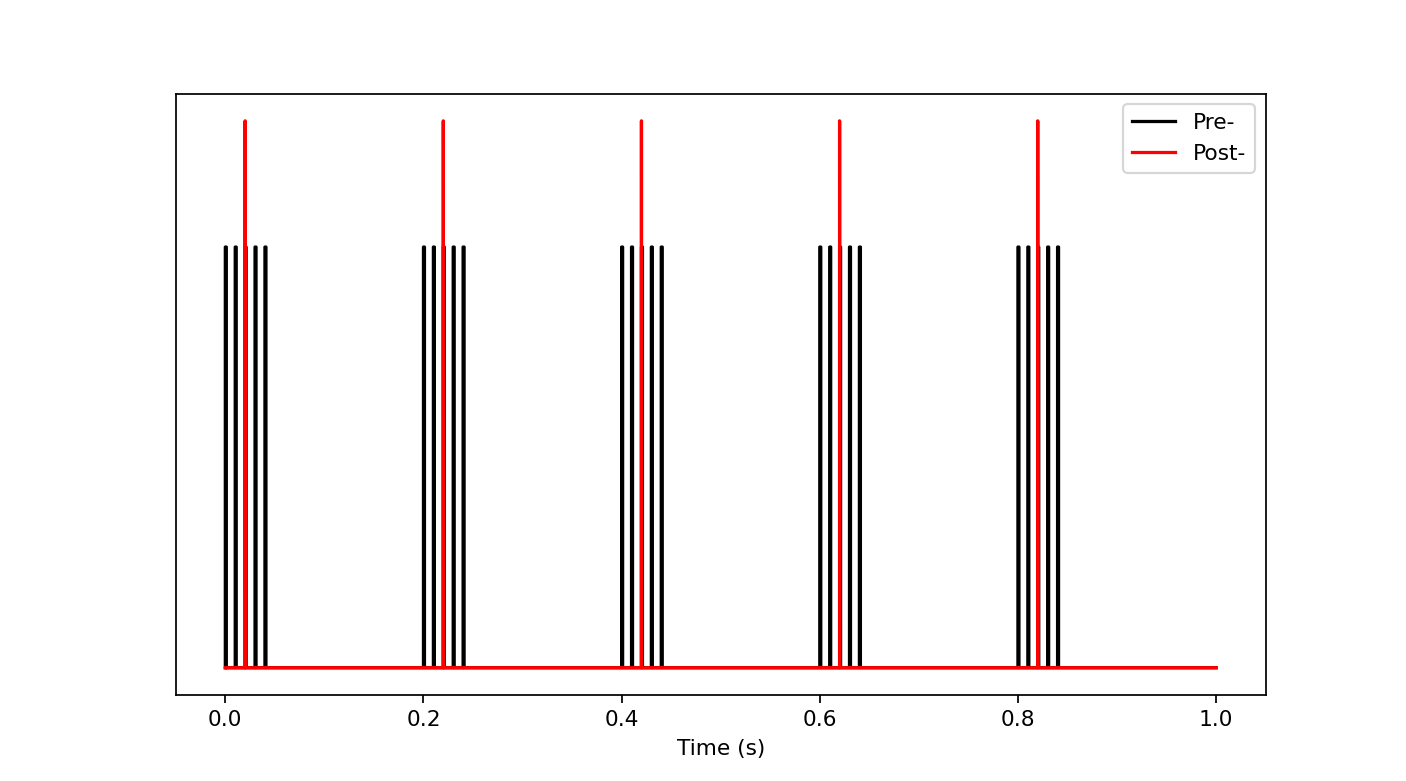

In [5]:
pre, post = Stimulation_Pattern_Design(PARAMETERS,plot=True)

In [6]:
'''
    2.
    
    RECEPTORS GATING SIMULATION
    
    Our model includes the gating simulation of NMDARs and AMPARs present on the membrane of CA1 pyramidal neuron.
    This simulation is based on two different kinetic models (one for each receptor) implemented as systems of differential ù
    equations in a PySB model. These models describe the states transition that the receptors face, from the binding with the 
    neurotransmitter to the actual opening of the channel, passing through pre-opening and desensitization states.
    
    In this section you can simulate the receptors gating kinetic model, which will predict the fractions of the two receptors 
    populations which open over the time, using as input the glutamate pulses (pre-synaptic stimulation) designed in the 
    previous step.
 
'''

results_RGS = Receptors_Gating_Simulation(PARAMETERS,plot=False)


Simulating Synaptic Cleft compartment ... Done !


In [7]:
'''
    3.
    
    EPSPs/EPSCs CALCULATION
    
    In this section the trajectories of the open states of both AMPA and NMDA receptors calculated in the second step are 
    used to simulate the respective excitatory post-synaptic currents (EPSCs) and potentials (EPSPs). Since calcium is
    a key mediator in Schaffer collateral synapses, driving different transmission-related phenomena such as synaptic 
    plasticity or post-synaptic cell excitotoxicity, the Ca2+ component of the total NMDARs-mediated current is then calculated.
    
'''

results_CPC= EPSCs_EPSPs_Calculation(PARAMETERS,results_RGS['O_AMPA'],results_RGS['O_NMDA'],plot=False)


EPSCs/EPSPs Calculation is running ...
Progress: |██████████████████████████████████████████████████| 100.0% Complete



Simulating Spine Compartment ...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


<IPython.core.display.Javascript object>


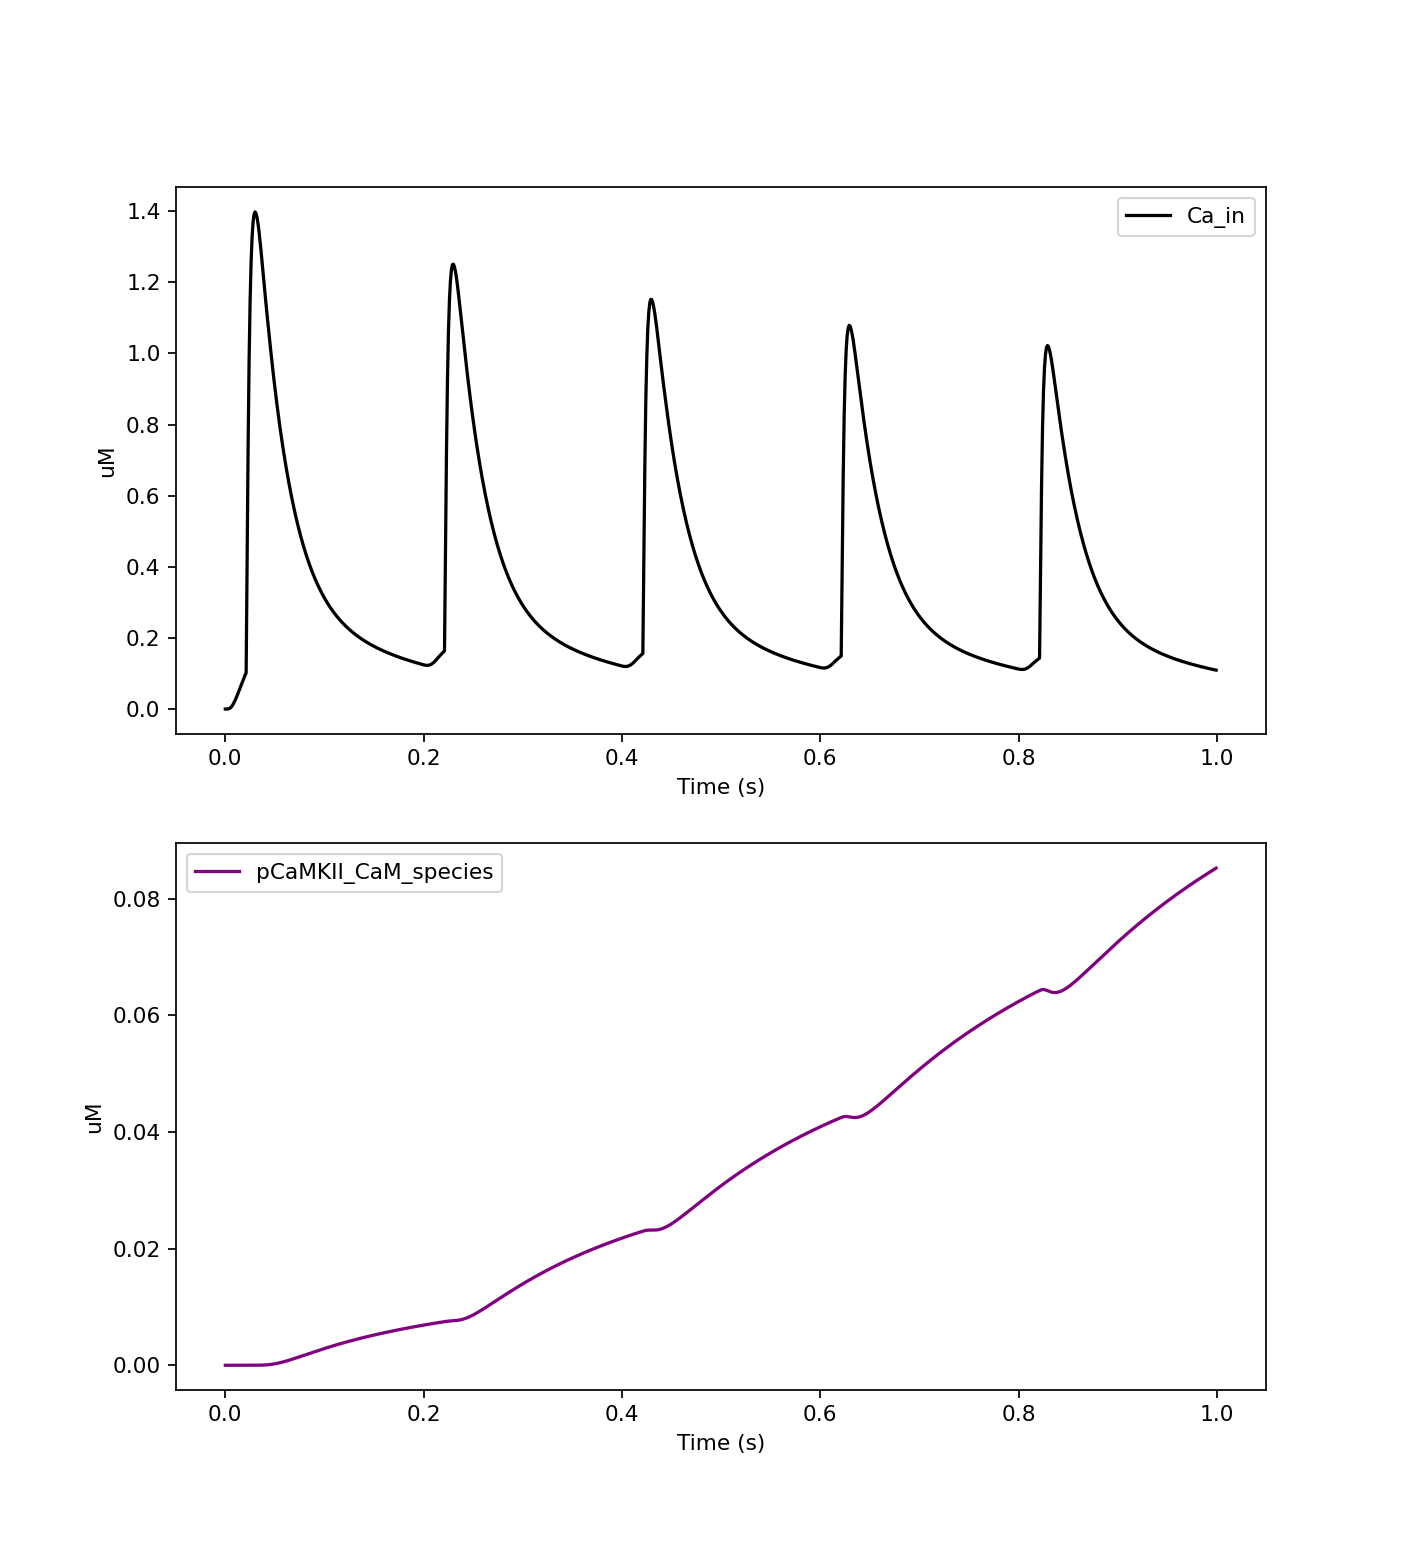

In [8]:
'''
    4.
    
    CaMKII KINETIC SIMULATION
    
    In this last section of the framework the inward Ca2+ current previousely calculated is feed into another PySB model
    containg a system of diferential equations describing the reversible Ca2+/CaM, Ca2+/CaMKII, CaM/CaMKII interaction
    and the irreversible CaMKII autophosphorylation reaction.
    
'''

results_CAS = CaMKII_Activation_Simulation(PARAMETERS, results_CPC['Ca_spine'],plot=True)